# Tasks for homework 4



## Task 1

Consider a following model:

$$f(x_1, x_2) = (x_1 + x_2)^2$$

Assume that $$x_1, x_2 ∼ U[-1,1]$$ and $x_1=x_2$ (full dependency)

Calculate PD profile for variable $x_1$ in this model.

Extra task if you do not fear conditional expected values: Calculate ME and ALE profiles for variable $x_1$ in this model.

## Solution


The value of a PD profile for model $f$ and explanatory variable $X^j$ at $z$ is defined as follows:

$$g_{PD}^{j}(z) = E_{\underline{X^{-j}}}\{f\left(X^{j|=z}\right)\}$$

Thus, it is the expected value of the model predictions when $X^j$ is fixed at $z$ over the (marginal) distribution of $\underline{X^{-j}}$, i.e., over the joint distribution of all explanatory variables other than $X_j$. Or, in other words, it is the expected value of the CP profile for $X^j$ over the distribution of $\underline{X^{-j}}$.

Source: [Explanatory Model Analysis](https://ema.drwhy.ai/partialDependenceProfiles.html)


With that information we have:

$$g_{PD}^{1}(z) = E_{x_2} f(X^{j|=z}) =  E_{x_2}[(z + x_2)^2]  $$

$$=  E_{x_2}[z^2 + 2x_2z + x_2^2] = z^2 + 2zE_{x_2}[x_2] + E_{x_2}[x_2^2] = z^2 + \frac{1}{3}$$

## Task 2

1. For the selected data set, train at least one tree-based ensemble model, e.g. random forest, gbdt, xgboost.
2. Calculate the predictions for some selected observations.
3. Then, calculate the what-if explanations of these predictions using Ceteris Paribus profiles (also called What-if plots), e.g. in Python: `AIX360`, `Alibi`, `dalex`, `PDPbox`; in R: `pdp`, `DALEX`, `ALEplot`. *implement CP yourself for a potential bonus point*
4. Find two observations in the data set, such that they have different CP profiles. For example, model predictions are increasing with age for one observation and decreasing with age for another one. NOTE that you will need to have a model with interactions to observe such differences.
5. Compare CP, which is a local explanation, with PDP, which is a global explanation. *implement PDP yourself for a potential bonus point*
Compare PDP between between at least two different models.
6. COMMENT on the results obtained in (2)-(5)

# Report 



In this homework I again continue with analyzing math and portuguese dataset separetly. As it turned out the dataset needed small fix -- in both datasets we had two classes that had only one observation. Due to that it was impossible to stratify the train/test split and calculate precision and recall (division by zero error). I've decided to remove these classes from the dataset as they only generate noise and can't be evaluated in any way. 

I again choose the xgboost model. Below there are some statistics from both of the models:
- math
  
  - 	recall: 1.0	
  -   precision: 0.142857	
  -   f1: 0.25	
  -   accuracy: 0.333333
  -  	auc: 0.493685

- portugese 
  - 	recall: 1.0	
  -   precision: 0.333333
  -   f1: 0.5
  -   accuracy: 0.5
  -  	auc: 0.490316
  

I've selected two observations from the test set: one which had correct prediction and one with wrong prediction (because there might be some interesting things in the explanaitions). 

For the math dataset we got following plots for features `age` abd `absences`:
- correct (on the left) and wrong (on the right) prediction

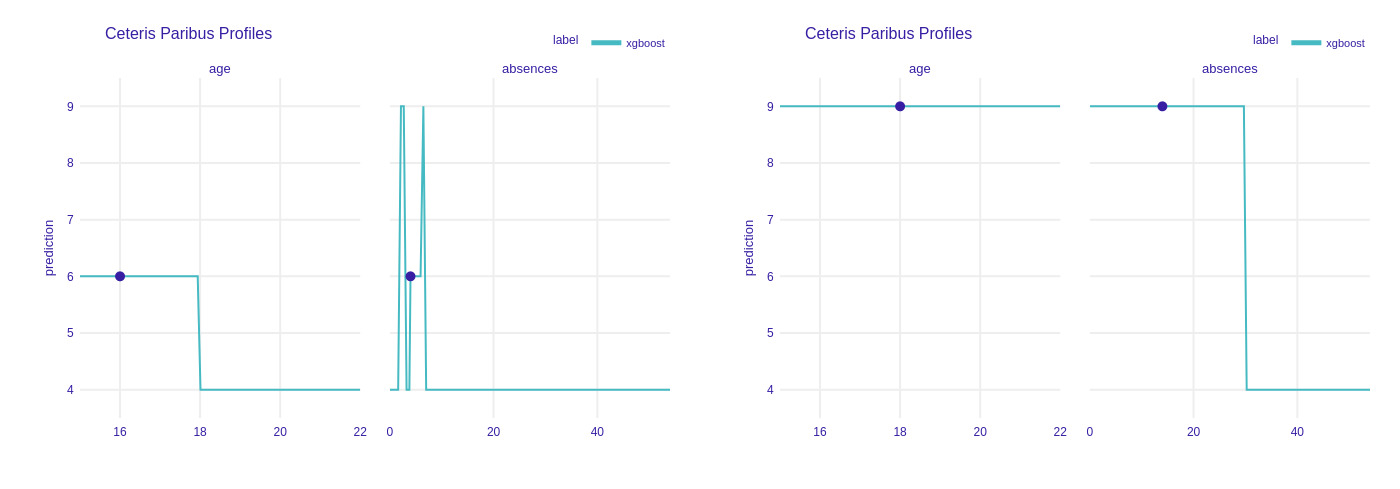

On the plot above we can see a few interesting observations:
- For the correct prediction, when a child gets older it's more likely to have lower results 
- For correct prediction, some small number of absences can be beneficial for grades (1 or 4)
- For the wrong prediction, age doesn't have much influence on the grades
- For the wrong prediction, more than 30 absences can lower the grades even by 5


In this case we have two obserations with different CP profile in case of `age` variable. 

For the portugese dataset we got following plots for features `age` abd `absences`:
- correct (on the left) and wrong (on the right) prediction

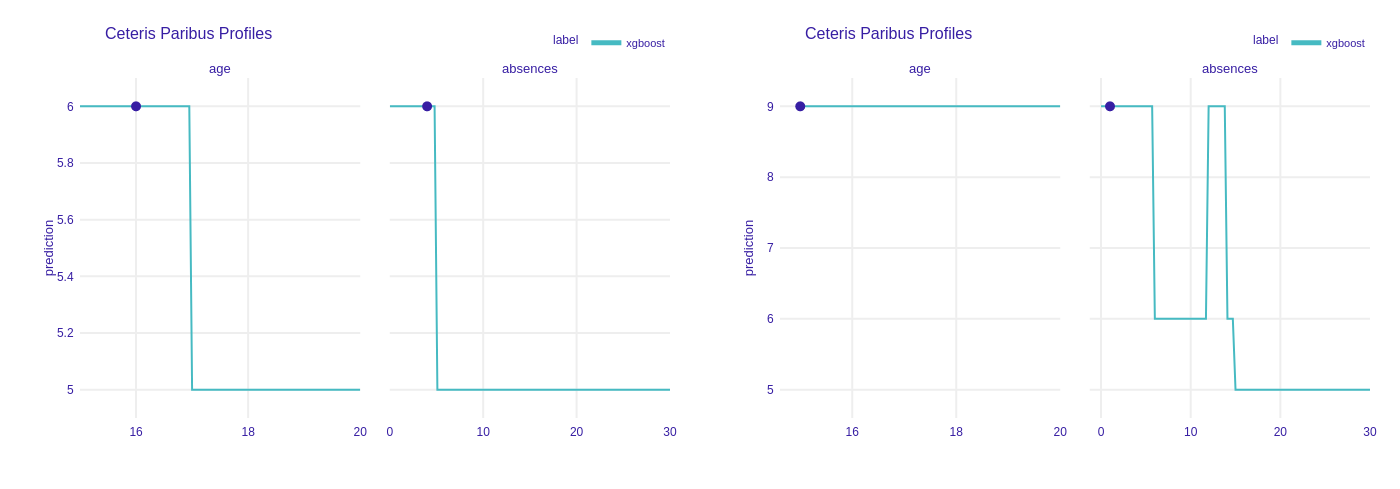

Observations from the plots above:
- For the correct prediction, teenagers from the age of 17 may have lower grades
- For the correct prediction, children have to attend classes in order to have higher grades (it's probably also the case for students, but classes so early in the morning are almost impossible to attend :< )
- For the wrong prediction, age seems to not have an effect on the grades
- For the wrong prediction, somewhat between 11 and 12 absences seem to have good effects on the grades

In this case we also have different profiles for `age` variable.

The next step was using Partial Dependenence Plots. On the plots below we can see some plots for two math models: previous models (on the left) and bigger model (on the right).

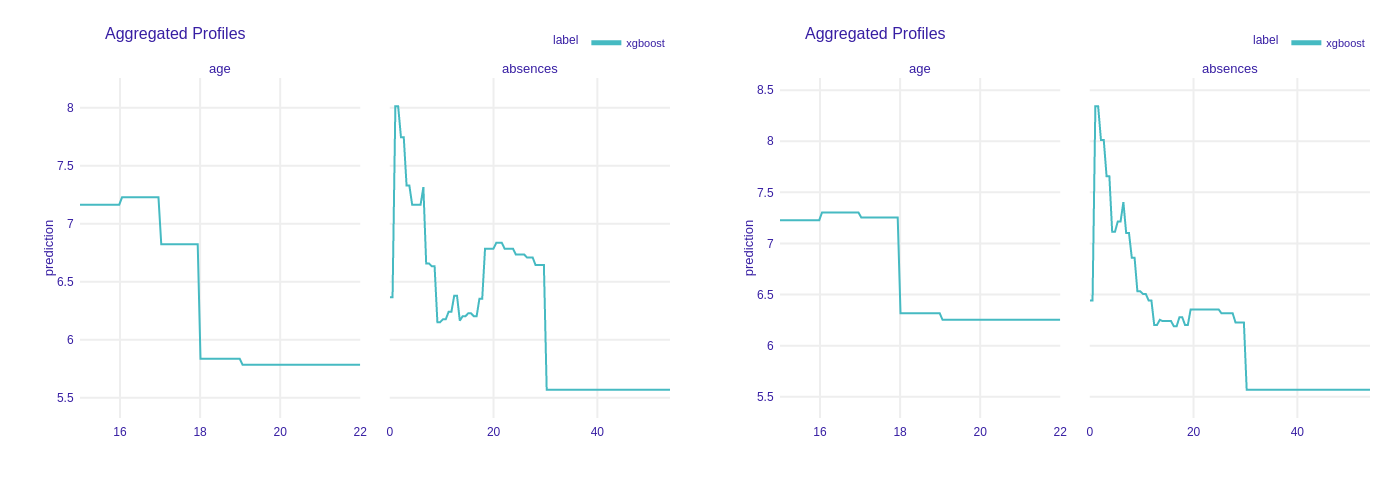

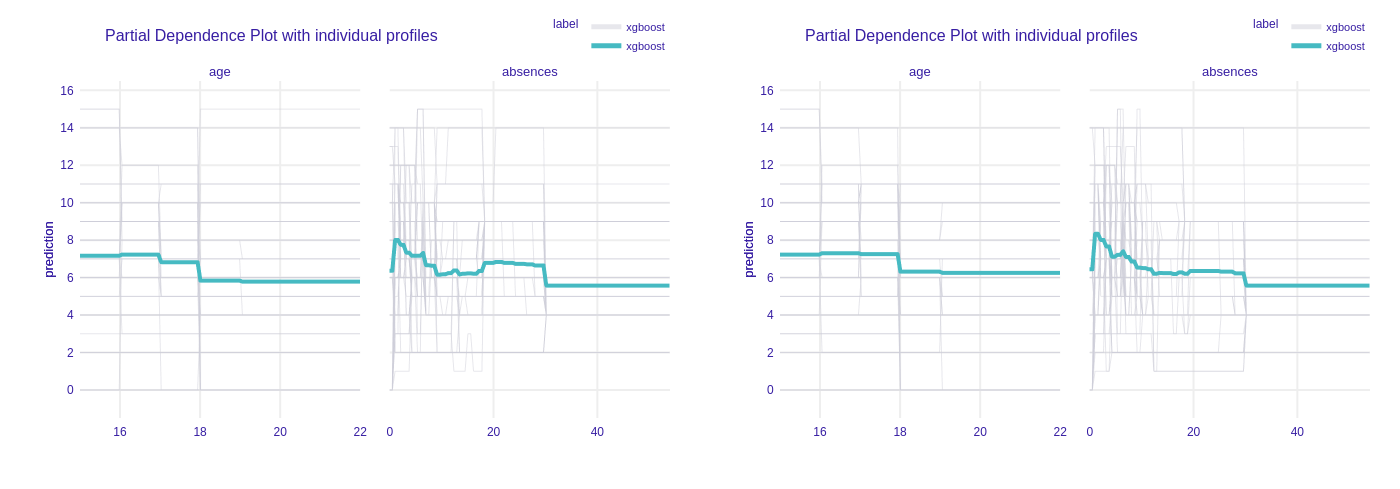

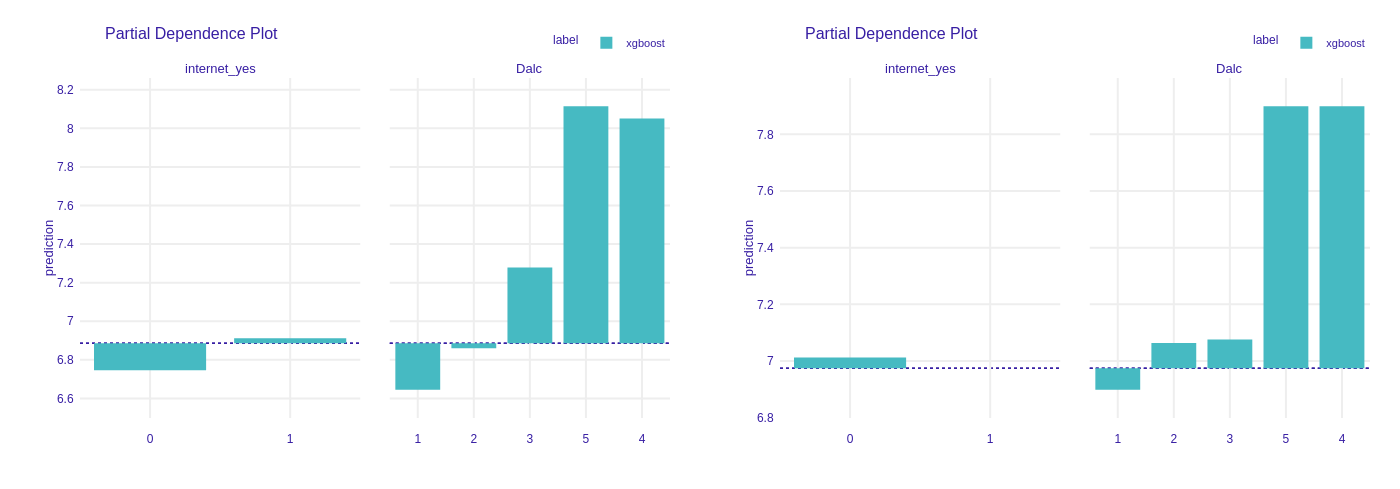

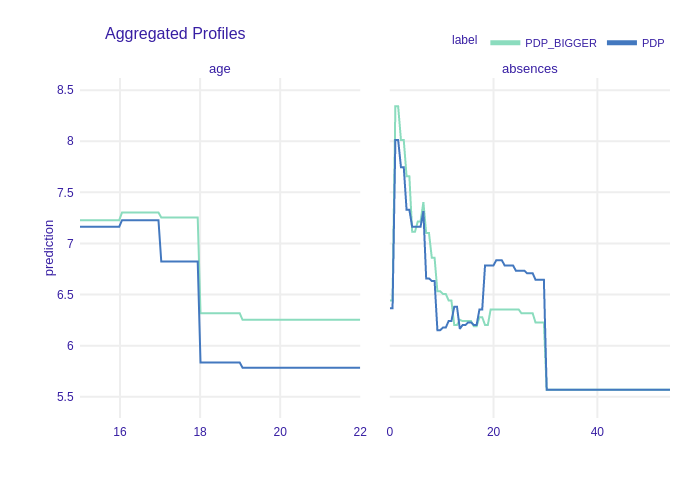

From the plots above we can see that bigger model is more stable in a sense: there are less of a sharp rises especially for the `absence` variable. On the categorial plot we can see interesting observation: for the smaller model no access to the internet have negative impact on the grades, for the bigger models it's the other way around.

Similarly for the portuguese dataset:

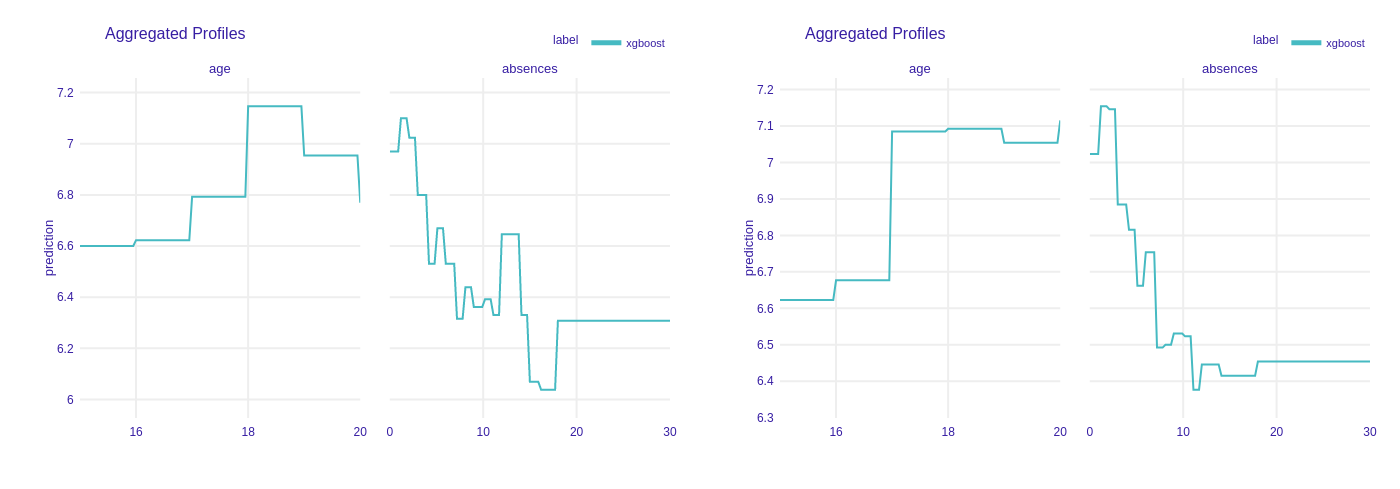

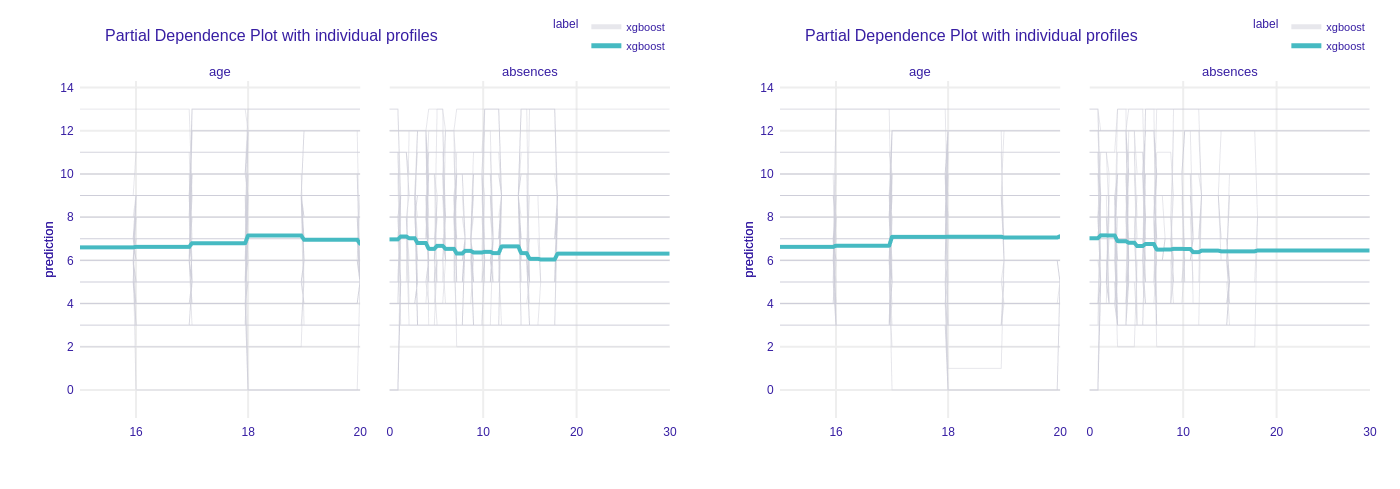

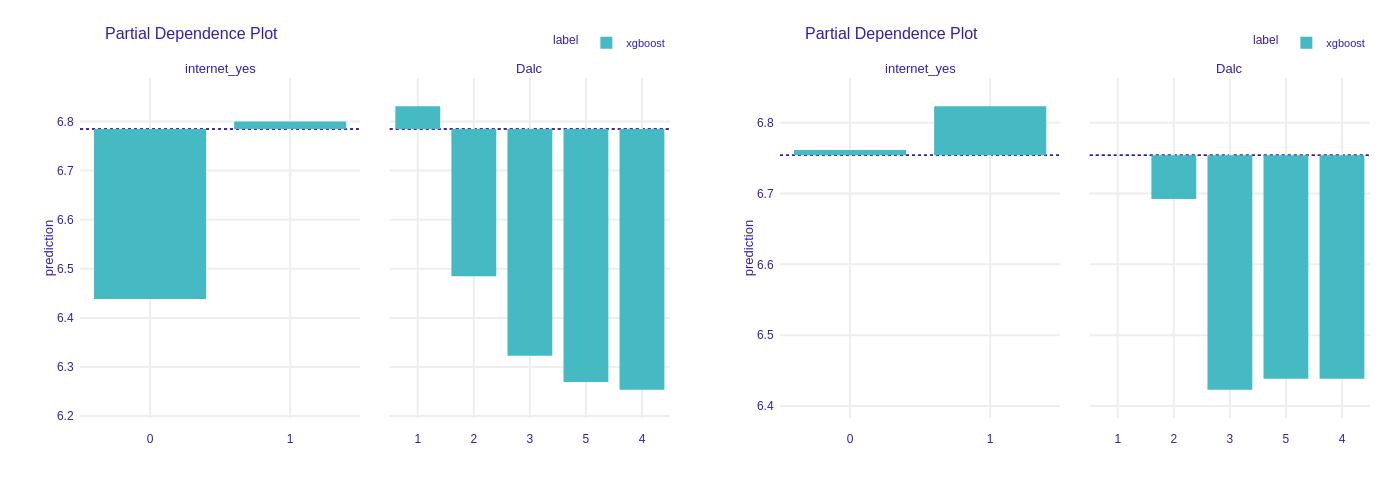

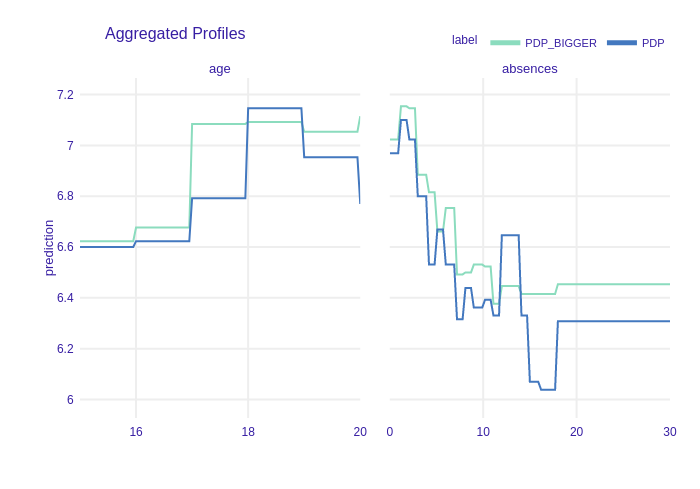

Again for the bigger model, curves seem to be more smooth for the bigger model. For the `age` variable we have different trend than on the CP plots -- marks tend to be higher with increasing age. We have also significant difference in the access to the internet in both models: in the smaller one no access to the internet drastically decrease the prediction. In the bigger one the prediction grows for no internet access.

# Appendix

## Setup

In [87]:
! pip install alibi >/dev/null 2>&1
! pip install dalex >/dev/null 2>&1
! pip install 'xgboost==1.6.2' >/dev/null 2>&1
! pip install -U kaleido >/dev/null 2>&1

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import dalex as dx
import numpy as np
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import collections

In [3]:
from google.colab import files
files.upload()
print(' ')

Saving archive.zip to archive.zip
 


In [20]:
! unzip archive.zip -d data

Archive:  archive.zip
replace data/Maths.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/Maths.csv          
replace data/Portuguese.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/Portuguese.csv     


## Data Preparation

In [2]:
df_math = pd.read_csv('/content/data/Maths.csv')
df_port = pd.read_csv('/content/data/Portuguese.csv')

In [3]:
def get_one_hot_columns(df):
  one_hot_columns = []
  for column in df.columns:
    if df[column].dtype == 'object':
      one_hot_columns.append(column)
  return one_hot_columns

In [4]:
df_math = pd.get_dummies(df_math, columns=get_one_hot_columns(df_math), drop_first=True)
df_port = pd.get_dummies(df_port, columns=get_one_hot_columns(df_port), drop_first=True)

In [5]:
 # In math dataset class 20 occurs only once, so we delete it so it doesn't counfuse classifiers later
collections.Counter(df_math['G3'])

Counter({6: 15,
         10: 56,
         15: 33,
         11: 47,
         19: 5,
         9: 28,
         12: 31,
         14: 27,
         16: 16,
         5: 7,
         8: 32,
         17: 6,
         18: 12,
         13: 31,
         20: 1,
         7: 9,
         0: 38,
         4: 1})

In [6]:
df_math = df_math[df_math['G3'] != 20]
df_math = df_math[df_math['G3'] != 4]

In [7]:
 # In math dataset classes 1 and 5 occure only once, so we delete it so it doesn't counfuse classifiers later
collections.Counter(df_port['G3'])

Counter({11: 104,
         12: 72,
         14: 63,
         13: 82,
         17: 29,
         15: 49,
         7: 10,
         10: 97,
         16: 36,
         9: 35,
         8: 35,
         18: 15,
         6: 3,
         0: 15,
         1: 1,
         5: 1,
         19: 2})

In [8]:
df_port = df_port[df_port['G3'] != 1]
df_port = df_port[df_port['G3'] != 5]

In [9]:
X_math = df_math.copy()
X_math = X_math.drop(['G3', 'G2', 'G1'], axis=1)
y_math = df_math['G3']

X_port = df_port.copy()
X_port = X_port.drop(['G3', 'G2', 'G1'], axis=1)
y_port = df_port['G3']

In [10]:
prev_math = list(set(y_math))
prev_port = list(set(y_port))

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_math = le.fit_transform(y_math)
y_port = le.fit_transform(y_port)

In [12]:
encoded_math = list(set(y_math))
encoded_port = list(set(y_port))

In [13]:
def label_encoding(prev, encoded):
  encoded_to_prev_label = {}
  for p, e in zip(prev, encoded):
    encoded_to_prev_label[e] = p
  return encoded_to_prev_label

In [14]:
encoded_to_prev_label_math = label_encoding(prev_math, encoded_math)
encoded_to_prev_label_port = label_encoding(prev_port, encoded_port)

In [15]:
 # In math dataset class 17 occurs only once, so we delete it so it doesn't counfuse classifiers later
collections.Counter(y_math)

Counter({2: 15,
         6: 56,
         11: 33,
         7: 47,
         15: 5,
         5: 28,
         8: 31,
         10: 27,
         12: 16,
         1: 7,
         4: 32,
         13: 6,
         14: 12,
         9: 31,
         3: 9,
         0: 38})

In [16]:
X_math_train, X_math_test, y_math_train, y_math_test = train_test_split(X_math, y_math, test_size=0.2, random_state=42, stratify=y_math)
X_port_train, X_port_test, y_port_train, y_port_test = train_test_split(X_port, y_port, test_size=0.2, random_state=42, stratify=y_port)

## XBoost model for math

### Model for math

In [17]:
xgb_math = xgb.XGBClassifier(
    n_estimators=200, 
    max_depth=4, 
    use_label_encoder=False, 
    eval_metric="logloss",
    enable_categorical=False,
    tree_method="hist"
)

In [42]:
xgb_math_bigger = xgb.XGBClassifier(
    n_estimators=1000, 
    max_depth=7, 
    use_label_encoder=False, 
    eval_metric="logloss",
    enable_categorical=False,
    tree_method="hist"
)

In [43]:
xgb_math_bigger.fit(X_math_train, y_math_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=7,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [18]:
xgb_math.fit(X_math_train, y_math_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [19]:
# sample1 = np.random.randint(len(X_math_test))
# sample2 = np.random.randint(len(X_math_test))
# print(sample1, sample2)

In [20]:
sample1 = 3
sample2 = 60

In [21]:
xgb_math.predict(X_math_test.take([sample1])).item(), y_math_test.take([sample1]).item()

(6, 6)

In [22]:
xgb_math.predict(X_math_test.take([sample2])).item(), y_math_test.take([sample2]).item()

(9, 1)

In [23]:
X_math_sample = X_math_test.take([sample1, sample2])
X_math_sample = X_math_sample.reset_index(drop=True)

### Dalex for math

In [24]:
def pf_xgboost_classifier(model, df):
    return np.argmax(model.predict_proba(df),axis=-1)

explainer = dx.Explainer(xgb_math, X_math_test, y_math_test, predict_function=pf_xgboost_classifier, label='xgboost')

Preparation of a new explainer is initiated

  -> data              : 79 rows 39 cols
  -> target variable   : 79 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : xgboost
  -> predict function  : <function pf_xgboost_classifier at 0x7f6e702ca9e0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 6.89, max = 15.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -12.0, mean = -0.203, max = 10.0
  -> model_info        : package xgboost

A new explainer has been created!


In [44]:
explainer_bigger = dx.Explainer(xgb_math_bigger, X_math_test, y_math_test, predict_function=pf_xgboost_classifier, label='xgboost')

Preparation of a new explainer is initiated

  -> data              : 79 rows 39 cols
  -> target variable   : 79 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : xgboost
  -> predict function  : <function pf_xgboost_classifier at 0x7f6e702ca9e0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 6.97, max = 14.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -14.0, mean = -0.291, max = 9.0
  -> model_info        : package xgboost

A new explainer has been created!


In [25]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
xgboost,1.0,0.142857,0.25,0.333333,0.493685


In [45]:
explainer_bigger.model_performance()

,recall,precision,f1,accuracy,auc
xgboost,1.0,0.142857,0.25,0.333333,0.494928


### Ceteris Paribus

In [27]:
cp_correct = explainer.predict_profile(new_observation=X_math_sample.loc[0])
fig = cp_correct.plot(variables=['age', 'absences'], show=False)
fig.write_image("cp_correct_math.png")

Calculating ceteris paribus: 100%|██████████| 39/39 [00:01<00:00, 21.67it/s]


In [29]:
cp_wrong = explainer.predict_profile(new_observation=X_math_sample.loc[1])
fig = cp_wrong.plot(variables=['age', 'absences'], show=False)
fig.write_image("cp_wrong_math.png")

Calculating ceteris paribus: 100%|██████████| 39/39 [00:02<00:00, 15.09it/s]


In [31]:
cp_10 = explainer.predict_profile(new_observation=X_math_test.iloc[0:10])
cp_10.plot(variables=['age', 'absences'])

Calculating ceteris paribus: 100%|██████████| 39/39 [00:04<00:00,  9.09it/s]


### Partial Dependence

In [32]:
pdp = explainer.model_profile()

Calculating ceteris paribus: 100%|██████████| 39/39 [00:07<00:00,  5.50it/s]


In [46]:
pdp_bigger = explainer_bigger.model_profile()

Calculating ceteris paribus: 100%|██████████| 39/39 [00:28<00:00,  1.36it/s]


In [51]:
pdp_num = explainer.model_profile(type="pdp", N=None, variables=["age", "absences"], label="PDP", verbose=False)
pdp_bigger_num = explainer_bigger.model_profile(type="pdp", N=None, variables=["age", "absences"], label="PDP_BIGGER", verbose=False)
fig = pdp_bigger_num.plot(pdp_num, show=False)
fig.write_image('two_models_math.png')

In [34]:
fig = pdp.plot(variables=['age', 'absences'], show=False)
fig.write_image("pdp_math.png")

In [47]:
fig = pdp_bigger.plot(variables=['age', 'absences'], show=False)
fig.write_image("pdp_bigger_math.png")

In [48]:
fig = pdp_bigger.plot(variables=['age', 'absences'], geom="profiles", title="Partial Dependence Plot with individual profiles", show=False)
fig.write_image("pdp_bigger_math_profiles.png")

In [36]:
fig = pdp.plot(variables=['age', 'absences'], geom="profiles", title="Partial Dependence Plot with individual profiles", show=False)
fig.write_image("pdp_math_profiles.png")

In [37]:
fig = explainer.model_profile(
    variable_splits={'internet_yes': X_math_test['internet_yes'].unique(), 'Dalc': X_math_test['Dalc'].unique()}, 
    verbose=False)\
.plot(geom="bars", title="Partial Dependence Plot", show=False)
fig.write_image("pdp_math_categorical.png")

/usr/local/lib/python3.7/dist-packages/dalex/predict_explanations/_ceteris_paribus/checks.py:16: UserWarning:

Variables taken from variables_splits



In [49]:
fig = explainer_bigger.model_profile(
    variable_splits={'internet_yes': X_math_test['internet_yes'].unique(), 'Dalc': X_math_test['Dalc'].unique()}, 
    verbose=False)\
.plot(geom="bars", title="Partial Dependence Plot", show=False)
fig.write_image("pdp_bigger_math_categorical.png")

/usr/local/lib/python3.7/dist-packages/dalex/predict_explanations/_ceteris_paribus/checks.py:16: UserWarning:

Variables taken from variables_splits



In [273]:
pdp_grouped = explainer.model_profile(groups="Dalc")

Calculating ceteris paribus: 100%|██████████| 39/39 [00:07<00:00,  5.13it/s]


In [274]:
pdp_grouped.plot(variables=["age", "absences"], title="PDP")

In [275]:
pdp_splits = explainer.model_profile(groups="Dalc", variable_splits_type="quantile")

Calculating ceteris paribus: 100%|██████████| 39/39 [00:01<00:00, 20.83it/s]


In [276]:
pdp_splits.plot(variables=["age", "absences"])

### Accumulated Local Effects

In [277]:
ale_num = explainer.model_profile(type="ale", variables=["age", "absences"], center=False)

Calculating accumulated dependency: 100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


In [278]:
ale_num.plot(title="Accumulated Local Effects")

### Comparing two explanaitions

In [279]:
ale_num = explainer.model_profile(type="ale", N=None, variables=["age", "absences"], label="ALE", verbose=False)
pdp_num = explainer.model_profile(type="pdp", N=None, variables=["age", "absences"], label="PDP", verbose=False)

In [280]:
ale_num.plot(pdp_num)

## XGBoost model for portugese

### Model

In [52]:
xgb_port = xgb.XGBClassifier(
    n_estimators=200, 
    max_depth=4, 
    use_label_encoder=False, 
    eval_metric="logloss",
    enable_categorical=False,
    tree_method="hist"
)

In [53]:
xgb_port_bigger = xgb.XGBClassifier(
    n_estimators=1000, 
    max_depth=7, 
    use_label_encoder=False, 
    eval_metric="logloss",
    enable_categorical=False,
    tree_method="hist"
)

In [54]:
xgb_port_bigger.fit(X_port_train, y_port_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=7,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [55]:
xgb_port.fit(X_port_train, y_port_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [70]:
sample1 = 8
sample2 = 3

In [71]:
xgb_port.predict(X_port_test.take([sample1])).item(), y_port_test.take([sample1]).item()

(6, 6)

In [72]:
xgb_port.predict(X_port_test.take([sample2])).item(), y_port_test.take([sample2]).item()

(9, 6)

In [73]:
X_port_sample = X_port_test.take([sample1, sample2])
X_port_sample = X_port_sample.reset_index(drop=True)

### Dalex for portugese

In [74]:
def pf_xgboost_classifier(model, df):
    return np.argmax(model.predict_proba(df),axis=-1)

explainer = dx.Explainer(xgb_port, X_port_test, y_port_test, predict_function=pf_xgboost_classifier, label='xgboost')

Preparation of a new explainer is initiated

  -> data              : 130 rows 39 cols
  -> target variable   : 130 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : xgboost
  -> predict function  : <function pf_xgboost_classifier at 0x7f6e6b9b94d0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 6.78, max = 13.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -6.0, mean = 0.223, max = 6.0
  -> model_info        : package xgboost

A new explainer has been created!


In [75]:
explainer_bigger = dx.Explainer(xgb_port_bigger, X_port_test, y_port_test, predict_function=pf_xgboost_classifier, label='xgboost')

Preparation of a new explainer is initiated

  -> data              : 130 rows 39 cols
  -> target variable   : 130 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : xgboost
  -> predict function  : <function pf_xgboost_classifier at 0x7f6e6b9b94d0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 6.75, max = 13.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -8.0, mean = 0.254, max = 8.0
  -> model_info        : package xgboost

A new explainer has been created!


In [76]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
xgboost,1.0,0.333333,0.5,0.5,0.490316


In [77]:
explainer_bigger.model_performance()

,recall,precision,f1,accuracy,auc
xgboost,1.0,0.333333,0.5,0.5,0.492109


### Ceteris Paribus

In [78]:
cp_correct = explainer.predict_profile(new_observation=X_port_sample.loc[0])
fig = cp_correct.plot(variables=['age', 'absences'], show=False)
fig.write_image("cp_correct_port.png")

Calculating ceteris paribus: 100%|██████████| 39/39 [00:00<00:00, 86.58it/s]


In [79]:
cp_wrong = explainer.predict_profile(new_observation=X_port_sample.loc[1])
fig = cp_wrong.plot(variables=['age', 'absences'], show=False)
fig.write_image("cp_wrong_port.png")

Calculating ceteris paribus: 100%|██████████| 39/39 [00:00<00:00, 54.14it/s]


### Partial dependence

In [80]:
pdp = explainer.model_profile()

Calculating ceteris paribus: 100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


In [81]:
pdp_bigger = explainer_bigger.model_profile()

Calculating ceteris paribus: 100%|██████████| 39/39 [01:05<00:00,  1.68s/it]


In [82]:
pdp_num = explainer.model_profile(type="pdp", N=None, variables=["age", "absences"], label="PDP", verbose=False)
pdp_bigger_num = explainer_bigger.model_profile(type="pdp", N=None, variables=["age", "absences"], label="PDP_BIGGER", verbose=False)
fig = pdp_bigger_num.plot(pdp_num, show=False)
fig.write_image('two_models_port.png')

In [84]:
fig = pdp.plot(variables=['age', 'absences'], show=False)
fig.write_image("pdp_port.png")

In [83]:
fig = pdp_bigger.plot(variables=['age', 'absences'], show=False)
fig.write_image("pdp_bigger_port.png")

In [85]:
fig = pdp_bigger.plot(variables=['age', 'absences'], geom="profiles", title="Partial Dependence Plot with individual profiles", show=False)
fig.write_image("pdp_bigger_port_profiles.png")

In [86]:
fig = pdp.plot(variables=['age', 'absences'], geom="profiles", title="Partial Dependence Plot with individual profiles", show=False)
fig.write_image("pdp_port_profiles.png")

In [87]:
fig = explainer.model_profile(
    variable_splits={'internet_yes': X_math_test['internet_yes'].unique(), 'Dalc': X_math_test['Dalc'].unique()}, 
    verbose=False)\
.plot(geom="bars", title="Partial Dependence Plot", show=False)
fig.write_image("pdp_port_categorical.png")

/usr/local/lib/python3.7/dist-packages/dalex/predict_explanations/_ceteris_paribus/checks.py:16: UserWarning:

Variables taken from variables_splits



In [88]:
fig = explainer_bigger.model_profile(
    variable_splits={'internet_yes': X_math_test['internet_yes'].unique(), 'Dalc': X_math_test['Dalc'].unique()}, 
    verbose=False)\
.plot(geom="bars", title="Partial Dependence Plot", show=False)
fig.write_image("pdp_bigger_port_categorical.png")